# Problem Session 2

In this problem session we practice our skills with :

* Exploratory Data Analysis
* Simple linear regression
* Multiple linear regression
* k nearest neighbors regression
* kFold cross validation

In [1]:
## We first load in packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style("whitegrid")

#### 1. Introducing the data

Our data concerns Median house prices for California districts derived from the 1990 census.

This dataset was found on Kaggle.com, <a href="https://www.kaggle.com/datasets/camnugent/california-housing-prices/data">https://www.kaggle.com/datasets/camnugent/california-housing-prices/data</a>.

##### a. 

First load the data for this problem. It is stored in the file `housing.csv` in the `data` folder of the repository. After loading the data look at the first five rows of the dataset. Then run `housing.info()`.  Are there any missing values?

##### Sample Solution

In [2]:
housing = pd.read_csv("../../data/housing.csv")
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  object 
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(8), object(2)
memory usage: 1.6+ MB


Yes, `total_bedrooms` has some missing values.

##### b. 

There are future lecture notebooks that cover ways to <i>impute</i> missing values, but for this notebook you will simply remove the missing values. 

Use `dropna`, <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html</a> to get a version of the data set that has had the missing values removed.


##### Sample Solution

In [3]:
## alternatively cars.dropna(inplace=True)
housing = housing.dropna()

##### c.

The column `median_house_value` currently contains strings instead of a floats.  Before doing any modeling you will have to clean the data a little bit.

Write a function `clean_column` which passes the indicated tests. 

Then use `.apply`, <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html</a> to apply clean_column to `median_house_value`.

### Sample Solution

In [4]:
def clean_column(text:str) -> float:
    text = text[1:] # removes leading $
    return float(text.replace(',','')) # removes comma and converts to float

assert clean_column('$432,425.0') == 432425.0
assert clean_column('$15,326.0') == 15326.0

In [5]:
housing['median_house_value'] = housing['median_house_value'].apply(clean_column)

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


### Predictive Model

In the next couple of problem session notebooks you will build a series of models to predict the sale price of a given vehicle.

#### 2. Train test split

The first step in predictive modeling is performing a train test split. Perform a train test split on these data, setting aside $20\%$ of the data as a test set. Choose a `random_state` so your results are reproducible.

As a refresher you can use `sklearn`'s `train_test_split` function: 

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html</a>.

##### Sample Solution

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
housing_train, housing_test = train_test_split(housing,
                                            test_size=0.2,
                                            random_state=216,
                                            shuffle=True)

assert(housing_train.shape[0] == int(housing.shape[0]*0.8))

#### 3. Exploratory data analysis (EDA)

After the train test split we can work on some exploratory data analysis. Here is where we start to look at the data and see if we can generate any modeling ideas or hypotheses. You will make a series of plots and learn a modeling trick that should improve any models we make.

##### a. 

Use `seaborn`'s `pairplot`, <a href="https://seaborn.pydata.org/generated/seaborn.pairplot.html">https://seaborn.pydata.org/generated/seaborn.pairplot.html</a> to plot `median_selling_value` against `km_driven`, `mileage` and `age`. Shell code is provided for you below.

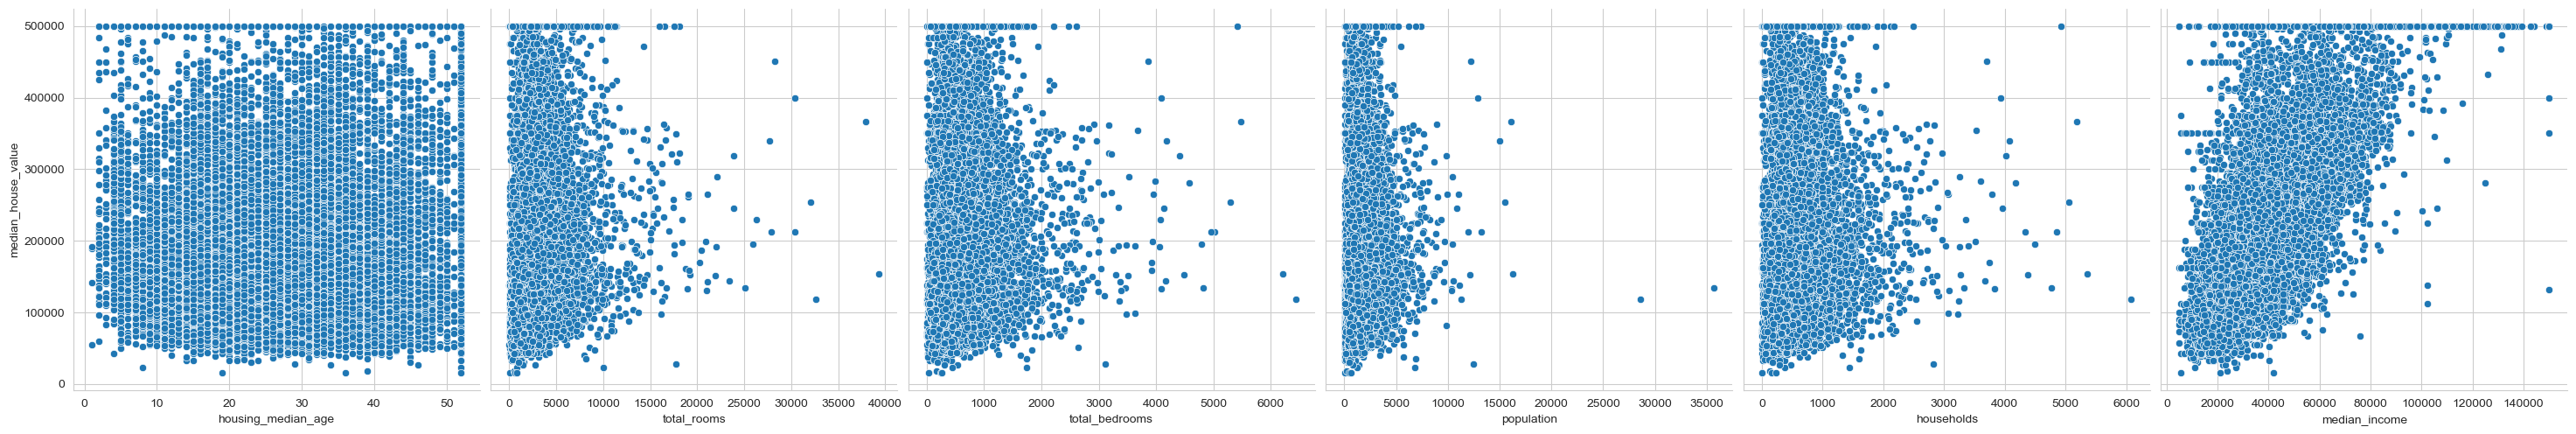

In [9]:
sns.pairplot(housing_train,
                y_vars = ['median_house_value'],
                x_vars = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population','households', 'median_income'],
                height = 5,
                diag_kind = None)

plt.show()

##### c.

Do any of the previous relationships look linear? Notice anything else interesting about the data?

##### Sample Solution

The relationship with median_income does appear roughly linear.  Hard to tell with some of the other variables.

I notice that `median_house_value` seems to have been truncated at $\$500000$.  This is a real problem for linear regression!  It will severely bias our estimates.

The easiest way to deal with this is to discard all of these rows.

A more complicated way would be to try and utilize those rows using something like a [Tobit Model](https://en.wikipedia.org/wiki/Tobit_model).

Let's take the easy way out for now.  This gives us another independent test of our model:  after training our model on the rest of the data we can see whether it predicts that those rows have a median value above $\$500000$.

In [10]:
# Set aside all of the rows for which the median house value is 500000
housing_truncated = housing[housing.median_house_value == 500000]
housing_train_truncated = housing_train[housing_train.median_house_value == 500000]
housing_test_truncated = housing_test[housing_test.median_house_value == 500000]

# Redefine these to only include the non-truncated examples
housing = housing[housing.median_house_value < 500000]
housing_train = housing_train[housing_train.median_house_value < 500000]
housing_test= housing_test[housing_test.median_house_value < 500000]

##### d.

Another part of EDA is calculating descriptive statistics.

One statistic of interest to us in this situation is the <i>Pearson correlation coefficient</i>. For two variables $x$ and $y$ with $n$ observations each, the Pearson correlation is given by:

$$
r = \frac{\sum_{i=1}^n \left( x_i - \overline{x} \right) \left( y_i - \overline{y}  \right)}{\sqrt{\sum_{i=1}^n \left(x_i - \overline{x}\right)^2 \sum_{i=1}^n \left(y_i - \overline{y} \right)^2}} = \frac{\text{cov}\left(x, y\right)}{\sigma_x \sigma_y},
$$

where $x_i$ is the $i^\text{th}$ observation, $\overline{x} = \sum_{i=1}^n x_i/n$, $\text{cov}\left( x, y \right)$ is the covariance between $x$ and $y$, and $\sigma_x$ denotes the standard deviation of $x$.

$r \in [-1,1]$ gives a sense of the strength of the linear relationship between $x$ and $y$. The closer $|r|$ is to $1$, the stronger the linear relationship between $x$ and $y$, the sign of $r$ determines the direction of the relationship, with $r < 0$ meaning a line with a negative slope and $r > 0$ a line with a positive slope.

Calculate the correlation between `median_house_value` and the columns you have previously plotted.

<i>Hint: Either <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html</a> or <a href="https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html">https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html</a> should work.</i>.

##### Sample Solution

In [11]:
# for your convenience I have copied the feature names here.
# you could instead get them programmatically by slicing the housing.columns array

features = ['median_house_value', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population','households', 'median_income']
housing[features].corr()

,median_house_value,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
median_house_value,1.000000,0.065761,0.144051,0.075219,0.012789,0.094630,0.646887
housing_median_age,0.065761,1.000000,-0.371440,-0.327505,-0.294337,-0.309331,-0.195024
total_rooms,0.144051,-0.371440,1.000000,0.934233,0.859769,0.921697,0.223963
total_bedrooms,0.075219,-0.327505,0.934233,1.000000,0.879269,0.979137,0.022125
population,0.012789,-0.294337,0.859769,0.879269,1.000000,0.909035,0.042740
households,0.094630,-0.309331,0.921697,0.979137,0.909035,1.000000,0.046639
median_income,0.646887,-0.195024,0.223963,0.022125,0.042740,0.046639,1.000000


##### e.

Based on your EDA, which feature do you think would best predict `median_house_value` in a simple linear regression model?

WARNING:  while using feature/outcome correlation is a reasonable choice for feature selection in a simple linear regression model, it is **not** a good choice for multiple linear regression.  [This stats.stackexchange post](https://stats.stackexchange.com/a/139031/97124) explains why!

##### Sample Solution

`median_income`

##### f.

We have not yet investigated *spatial* variation in the housing prices.

Use [https://plotly.com/python/mapbox-density-heatmaps/](https://plotly.com/python/mapbox-density-heatmaps/) as inspiration and make a heatmap of `median_house_value`.

Does it seem like including the latitude and longitude somehow in our model would be helpful?

In [12]:
fig = px.density_mapbox(housing, lat='latitude', lon='longitude', z='median_house_value', radius=2,
                        center=dict(lat=37, lon=-120), zoom=4,
                        mapbox_style="open-street-map")
fig.show()

#### 4. Modeling

Now you will build some preliminary models for this data set.

##### a.

When doing predictive modeling it is good practice to have a <i>baseline model</i> which is a simple "model" solely for comparison purposes. These are not, typically, complex or good models, but they are important reference points to give us a sense of how well our models are actually performing.

A standard regression model baseline is to just predict the average value of $Y$ for any value of $X$. In this setting that model looks like this:

$$
\text{Baseline Model: } \ \ \ \ \text{Median House Value} = \mathbb{E}\left(\text{Median House Value}\right) + \epsilon,
$$

where $\epsilon$ is i.i.d. and normally distributed.

Write some code to estimate $\mathbb{E}\left(\text{Median House Value}\right)$ using the training set.

##### Sample Solution

In [13]:
housing_train.median_house_value.mean()

192019.52563608327

Below you will use cross-validation to compare one simple linear regression models, one multiple linear regression model, and one kNN model which uses the spatial data.

$$
\begin{align*}
\text{Baseline Model}:& \ \text{Median House Value} = \mathbb{E}\left(\text{Median House Value}\right) + \epsilon\\

\text{SLR Model}:& \ \text{Median House Value} = \beta_0 + \beta_1 \left( \text{Median Income} \right) + \epsilon\\

\text{MLR model}:& \ \text{Median House Value} = \beta_0 + \beta_1 \left(\text{Median Income}\right)  + \beta_2 \left(\text{Households}\right) + \epsilon\\

\text{kNN model}:& \ \text{Use k nearest neighbors regression on latitude and longitude with $k = 10$}\\
\end{align*}
$$

We will attempt hyperparameter tuning on $k$ in a later problem session, but just stick with $k=10$ for now.

##### b.
In this problem practice fitting just the MLR model using the training set and `sklearn`'s `LinearRegression` model, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html</a>.

##### Sample Solution

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
mlr_model = LinearRegression()

mlr_model.fit(housing_train[['median_income', 'households']], housing_train.median_house_value)

LinearRegression()

In [16]:
mlr_model.intercept_

36750.815833249595

In [17]:
mlr_model.coef_

array([ 4.00432208, 15.88588526])

##### c.

In this problem you will try to implement $5$-fold cross-validation (CV) to compare these three models and the baseline model to see which one has the lowest average cross-validation root mean squared error (RMSE).

Because this may be your first time implementing CV, some of the code will be filled in for you.

##### Sample Solution

In [18]:
## import KFold and kNeighborsRegressor here
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor

## import root_mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [19]:
## Make a KFold object
## remember to set a random_state and set shuffle = True
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 216,
              shuffle=True)

## This array will hold the mse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(housing_train):
    ## cv training set
    housing_tt = housing_train.iloc[train_index]
    
    ## cv holdout set
    housing_ho = housing_train.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = housing_tt.median_house_value.mean()*np.ones(len(housing_ho))
    
    rmses[0, i] = root_mean_squared_error(housing_ho.median_house_value, baseline_pred)
    
    ## Fit and get ho mse for slr model
    slr = LinearRegression()
    
    slr.fit(housing_tt[['median_income']],housing_tt.median_house_value)
    
    rmses[1, i] = root_mean_squared_error(housing_ho.median_house_value, slr.predict(housing_ho[['median_income']]))
    
    
    ## Fit and get ho mse for mlr model
    mlr = LinearRegression()
    
    mlr.fit(housing_tt[['median_income', 'households']],housing_tt.median_house_value)
    
    rmses[2, i] = root_mean_squared_error(housing_ho.median_house_value, mlr.predict(housing_ho[['median_income', 'households']]))
    

    ## Fit and get ho mse for the spatial model
    knn = KNeighborsRegressor(10)
    
    knn.fit(housing_tt[['latitude', 'longitude']],housing_tt.median_house_value)
    
    rmses[3, i] = root_mean_squared_error(housing_ho.median_house_value, knn.predict(housing_ho[['latitude', 'longitude']]))
    
    i = i + 1

In [20]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"SLR Avg. CV MSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"MLR Avg. CV MSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Spatial Avg. CV MSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")


Baseline Avg. CV RMSE: 97155.61308813898 and STD: 1732.6162597213981
SLR Avg. CV MSE: 73989.14317308285 and STD: 852.6007728277376
MLR Avg. CV MSE: 73740.27469956284 and STD: 863.7332105557942
Spatial Avg. CV MSE: 49230.07148179809 and STD: 1138.5514425007118


##### d.

Which model had the lowest average cross validation root mean squared error?  

Discuss the meaning of the STD in this context.

##### Sample Solution

The spatial model performed the best, although this model is still not performing very well!  We will hopefully do better as we acquire more tools, but there are no magic bullets in machine learning.

The STD of the cross validation MSEs measures the variability in the cross validation MSEs across different splits.  If this number is small then the model performance is stable with respect to variation in training data.  If this number is large, then model performance is unstable.  There are times when you might prefer a model with higher average CV MSE because it has lower variability.  For instance, imagine the following 

Model 1 CV MSEs:  100, 101, 99

Model 2 CV MSEs:  10, 97, 190

Model 1 has mean CV MSE of 100 while model 2 has mean CV MSE of 99.  If you only looked at this statistic you might choose model 2, even though model 1 is clearly superior here.  We would expect Model 1 to generalize to the test set much more reliably than model 2.

##### e.

Train the simple linear regression model on the full training set and predict on the truncated dataset.  Does the model predict that the median house values are in excess of $\$500000$?

In [21]:
slr = LinearRegression()
slr.fit(housing_train[['median_income']],housing_train.median_house_value)
slr.predict(housing_train_truncated[['median_income']])

array([134325.81552994, 274300.31801858, 187820.28072057, 155534.56101492,
       179659.35817382,  94957.10686184, 173706.59061877, 316633.34404349,
       194102.86377529, 192115.92649678, 124057.29149749, 286181.72028724,
       233531.90454699, 187064.11835547, 218625.85281793, 221027.07054115,
       249805.48395761, 210637.8823015 ])

These are pretty far away from $\$500000$.  Seems like our model is doing pretty poorly (at least at predicting the extremes)!  We will discuss more ways to assess model fit throughout the bootcamp.

That's it for this notebook. In the next couple of regression based notebooks we will build additional models for this data set.

--------------------------

This notebook was written for the Erdős Institute Data Science Boot Camp by Steven Gubkin.

Please refer to the license in this repo for information on redistribution.